In [11]:
import sys
import pandas as pd 
import numpy as np
sys.path.append("/home/anoldfriend/Workspace/MyRepo/thermodynamics/CaL/src/CaL-CC-HS")
from pyCaLPlant import Pinch_point_analyzer
CaLRepo = '/home/anoldfriend/Workspace/MyRepo/thermodynamics/CaL'
# print(CaLRepo)
sys.path.append(f"{CaLRepo}/utilities/")
from pyPinch import PyPinch
import json
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
def write_pyPinch_data_text(df,dT):
    data = {}
    data["CP"] = df["CP"]
    data["TSUPPLY"] = df["TSUPPLY"]
    data["TTARGET"] = df["TTARGET"]
    df = pd.DataFrame(data)
    df["CP"] = df["CP"]
    text = df.to_string(index=False)
    text = f'Tmin {dT} \n'+text
    return text

In [13]:
with open("./pa_debug.csv","r") as fp:
    df=pd.read_csv(fp,skiprows=1)
df.head()

,CP,TSUPPLY,TTARGET
0,1.396306,650.000000,20.000000
1,1.719197,650.000000,40.000000
2,2.115643,48.101281,539.297644
3,0.888252,20.000000,35.000000
4,13.944230,20.000000,28.797715


In [14]:
pa_text=write_pyPinch_data_text(df,dT=15)
pa_text

'Tmin 15 \n       CP    TSUPPLY    TTARGET\n 1.396306 650.000000  20.000000\n 1.719197 650.000000  40.000000\n 2.115643  48.101281 539.297644\n 0.888252  20.000000  35.000000\n13.944230  20.000000  28.797715'


Streams: 
{'type': 'HOT', 'cp': 1.396306, 'ts': 650.0, 'tt': 20.0, 'ss': 642.5, 'st': 12.5}
{'type': 'HOT', 'cp': 1.719197, 'ts': 650.0, 'tt': 40.0, 'ss': 642.5, 'st': 32.5}
{'type': 'COLD', 'cp': 2.115643, 'ts': 48.101281, 'tt': 539.297644, 'ss': 55.601281, 'st': 546.797644}
{'type': 'COLD', 'cp': 0.888252, 'ts': 20.0, 'tt': 35.0, 'ss': 27.5, 'st': 42.5}
{'type': 'COLD', 'cp': 13.94423, 'ts': 20.0, 'tt': 28.797715, 'ss': 27.5, 'st': 36.297715}
Tmin = 15.0

Temperature Intervals: 
Interval 0 : {'t1': 642.5, 't2': 546.797644, 'streamNumbers': [0, 1]}
Interval 1 : {'t1': 546.797644, 't2': 55.601281, 'streamNumbers': [0, 1, 2]}
Interval 2 : {'t1': 55.601281, 't2': 42.5, 'streamNumbers': [0, 1]}
Interval 3 : {'t1': 42.5, 't2': 36.297715, 'streamNumbers': [0, 1, 3]}
Interval 4 : {'t1': 36.297715, 't2': 32.5, 'streamNumbers': [0, 1, 3, 4]}
Interval 5 : {'t1': 32.5, 't2': 27.5, 'streamNumbers': [0, 3, 4]}
Interval 6 : {'t1': 27.5, 't2': 12.5, 'streamNumbers': [0]}

Problem Table: 
Interval 0

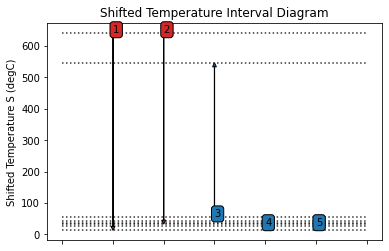

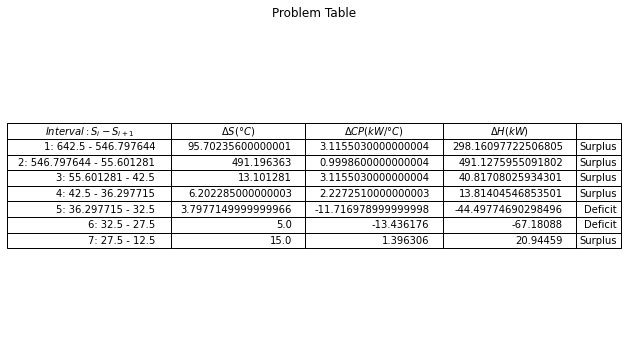

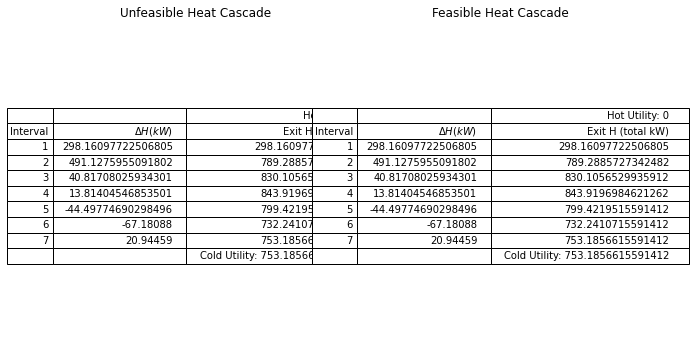

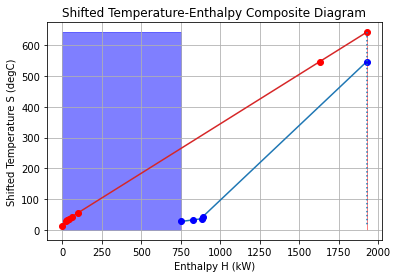

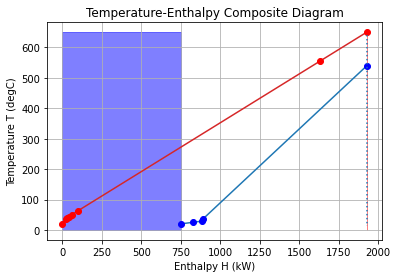

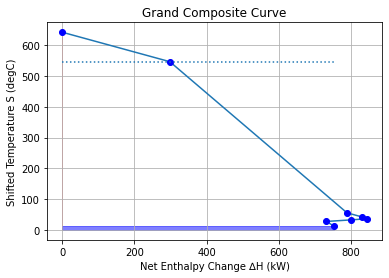

In [15]:
pinch = PyPinch(pa_text)
options = {'debug','draw'}
pinch.solve(options)

In [20]:

materials=["Ca","Gas","Gas","Ca","Water"]
HTCs={"Ca":300,"Water":2500,"Gas":600}
def myRound(a,ndigital=3):
    return round(a,ndigital)

hot_util = pinch.hotUtility*1e3  # W
cold_util=pinch.coldUtility*1e3  # W
HIntervalTable=pinch.constructEnthalpyIntervalTable()
streamPropertyTable=[]
for i,stream in enumerate(pinch.streams):
    record={}
    record["type"]=stream["type"]
    record["MCP"]=stream["cp"]
    record["HTC"]=HTCs[materials[i]]
    streamPropertyTable.append(record)
for record in HIntervalTable:
    hotStreams=record["hotStreams"]
    hotHTCs=[streamPropertyTable[i]["HTC"] for i in hotStreams]
    hotMCPs=[streamPropertyTable[i]["MCP"] for i in hotStreams]
    coldStreams=record["coldStreams"]
    coldHTCs=[streamPropertyTable[i]["HTC"] for i in coldStreams]
    coldMCPs=[streamPropertyTable[i]["MCP"] for i in coldStreams]
    record["hotQi"]=[myRound(cp*(record["hotshiftedTs"]-record["hotshiftedTt"])) for cp in hotMCPs]
    record["coldQi"]=[myRound(cp*(record["coldshiftedTt"]-record["coldshiftedTs"])) for cp in coldMCPs]
    hotHXA=[]
    coldHXA=[]
    for i,Qi in enumerate(record["hotQi"]):
        hotHXA.append(myRound(Qi/record["LMTD"]/hotHTCs[i]*1000))
    for i,Qi in enumerate(record["coldQi"]):
        coldHXA.append(myRound(Qi/record["LMTD"]/coldHTCs[i]*1000))
    record["hotHXA"]=hotHXA
    record["coldHXA"]=coldHXA

totalHXA=0
for record in HIntervalTable:
    for HXA in record["hotHXA"]:
        totalHXA=totalHXA+HXA
    for HXA in record["coldHXA"]:
        totalHXA=totalHXA+HXA

totalHXA


24.586000000000002

In [23]:
df=pd.DataFrame(HIntervalTable)
df.head(15)

,Hs,Ht,hotshiftedTs,hotshiftedTt,coldshiftedTs,coldshiftedTt,hotStreams,coldStreams,flux,LMTD,hotQi,coldQi,hotHXA,coldHXA
0,753.186,827.348,289.095,265.291,27.500,32.500,"[0, 1]","[3, 4]",74.162,262.080579,"[33.238, 40.924]","[4.441, 69.721]","[0.423, 0.26]","[0.056, 0.106]"
1,827.348,883.678,307.175,289.095,32.500,36.298,"[0, 1]","[3, 4]",56.330,278.675007,"[25.245, 31.083]","[3.374, 52.96]","[0.302, 0.186]","[0.04, 0.076]"
2,883.678,889.187,308.944,307.175,36.298,42.500,"[0, 1]",[3],5.509,283.654727,"[2.47, 3.041]",[5.509],"[0.029, 0.018]",[0.065]
3,916.184,1630.222,546.798,317.609,55.601,402.107,"[0, 1]",[2],714.038,212.991627,"[320.018, 394.021]",[733.083],"[5.008, 3.083]",[5.736]
4,1630.222,1928.383,642.500,546.798,402.107,546.798,"[0, 1]",[2],298.161,133.704044,"[133.629, 164.531]",[306.115],"[3.331, 2.051]",[3.816]


In [16]:
for interval in pinch.temperatureInterval:
    print(interval)

{'t1': 642.5, 't2': 546.797644, 'streamNumbers': [0, 1]}
{'t1': 546.797644, 't2': 55.601281, 'streamNumbers': [0, 1, 2]}
{'t1': 55.601281, 't2': 42.5, 'streamNumbers': [0, 1]}
{'t1': 42.5, 't2': 36.297715, 'streamNumbers': [0, 1, 3]}
{'t1': 36.297715, 't2': 32.5, 'streamNumbers': [0, 1, 3, 4]}
{'t1': 32.5, 't2': 27.5, 'streamNumbers': [0, 3, 4]}
{'t1': 27.5, 't2': 12.5, 'streamNumbers': [0]}


In [17]:
deltaHHots=[]
hotTs=set()
coldTs=set()
deltaHColds=[]
for interval in pinch.temperatureInterval:
    hotH = 0
    coldH = 0
    # Add CP values for the hot and cold streams
    # in a given temperature interval
    for i in interval['streamNumbers']:
        if pinch.streams.streamsData[i]['type'] == 'HOT':
            hotH = hotH + pinch.streams.streamsData[i]['cp']
        else:
            coldH = coldH + pinch.streams.streamsData[i]['cp']
    # Enthalpy = CP * deltaT
    hotH = hotH * (interval['t1'] - interval['t2'])
    deltaHHots.append(hotH)
    hotTs.add(interval['t1'])
    hotTs.add(interval['t2'])
    coldH = coldH * (interval['t1'] - interval['t2'])
    deltaHColds.append(coldH)
    coldTs.add(interval['t1'])
    coldTs.add(interval['t2'])


hotTs=list(hotTs)
hotTs.sort()
coldTs=list(coldTs)
coldTs.sort()
deltaHHots.reverse()
deltaHColds.reverse()

print(f"hotTs: {hotTs}")
print(f"coldTs: {coldTs}")
print(f"deltaHHots: {deltaHHots}")
print(f"deltaHColds: {deltaHColds}")


hotTs: [12.5, 27.5, 32.5, 36.297715, 42.5, 55.601281, 546.797644, 642.5]
coldTs: [12.5, 27.5, 32.5, 36.297715, 42.5, 55.601281, 546.797644, 642.5]
deltaHHots: [20.94459, 6.98153, 11.83179247564499, 19.32323752435501, 40.81708025934301, 1530.3237425155892, 298.16097722506805]
deltaHColds: [0.0, 74.16241, 56.329539378629946, 5.509192055820003, 0.0, 1039.196147006409, 0.0]


In [18]:
totalHotH = 0.0
shiftedCompositeDiagram={"hot":{"H":[],"T":[]},"cold":{"H":[],"T":[]}}
shiftedCompositeDiagram['hot']['H'].append(totalHotH)
shiftedCompositeDiagram['hot']['T'].append(hotTs[0])

for i in range(1, len(hotTs)):
    if deltaHHots[i - 1] != 0:
        totalHotH = totalHotH + deltaHHots[i - 1]
        shiftedCompositeDiagram['hot']['H'].append(totalHotH)
        shiftedCompositeDiagram['hot']['T'].append(hotTs[i])

totalColdH = pinch.coldUtility
print(totalColdH)

753.1856615591412


In [19]:
coldTs2=list()
deltaHColds2=list()
firstTemperature=0
for i in range(0, len(deltaHColds)):
    if deltaHColds[i] > 0:
        firstTemperature=coldTs[i]
        break
coldTs2.append(firstTemperature)
for i in range(0, len(deltaHColds)):
    if deltaHColds[i] > 0:
        coldTs2.append(coldTs[i+1])
        deltaHColds2.append(deltaHColds[i])

shiftedCompositeDiagram['cold']['H'].append(totalColdH)
shiftedCompositeDiagram['cold']['T'].append(coldTs2[0])

for i in range(1, len(coldTs2)):
    totalColdH = totalColdH + deltaHColds2[i-1]
    shiftedCompositeDiagram['cold']['H'].append(totalColdH)
    shiftedCompositeDiagram['cold']['T'].append(coldTs2[i])

shiftedCompositeDiagram



{'hot': {'H': [0.0,
   20.94459,
   27.92612,
   39.75791247564499,
   59.08115000000001,
   99.89823025934302,
   1630.2219727749323,
   1928.3829500000004],
  'T': [12.5, 27.5, 32.5, 36.297715, 42.5, 55.601281, 546.797644, 642.5]},
 'cold': {'H': [753.1856615591412,
   827.3480715591412,
   883.6776109377712,
   889.1868029935912,
   1928.3829500000002],
  'T': [27.5, 32.5, 36.297715, 42.5, 546.797644]}}